In [14]:
import numpy as np
import scanpy as sc
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    continuity_confidence,
    update_dict,
    cross_boundary_correctness,
)
from deepvelo.utils.scatter import scatter
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

In [15]:
adata = scv.datasets.bonemarrow()

In [16]:
adata = adata[~adata.obs["clusters"].isin(["CLP"]), :]

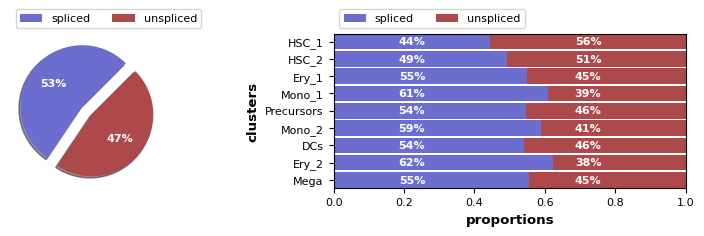

In [17]:
scv.pl.proportions(adata, groupby = "clusters")

In [18]:
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 1000)
scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

Filtered out 7875 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [19]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 53.1% (less than 70%). Suggest using coeff_s 0.5.


In [20]:
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [21]:
velocity(adata, mask_zero=False)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [22]:
trainer = train(adata, configs)

Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([5292, 1000])
confidence mse shape: (5292, 1000)
confidence mse stats: max 2904.127685546875, min 0.0, mean 0.32839447259902954, std 4.464992046356201
confidence corr shape: (1000,)
confidence corr stats: max 0.7532498240470886, min -0.5104408264160156, mean 0.48213350772857666, std 0.16100665926933289
velo_mat shape: (5292, 1000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [23]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/24 cores)


  0%|          | 0/5292 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


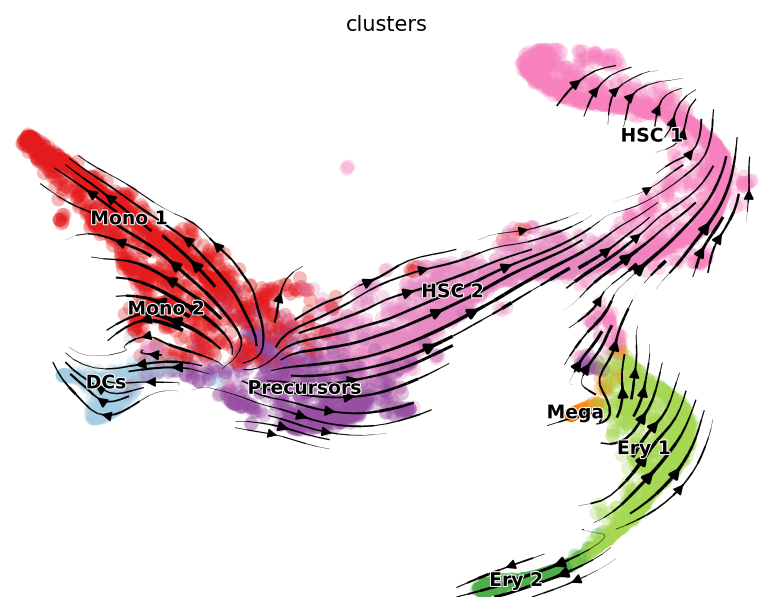

In [24]:
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150            # increase dpi for higher resolution
)

In [25]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [26]:
adata.write_h5ad("data/deepvelo.h5ad")